# PCA and Hierarchical Portfolio Optimisation

This code implements two main financial analysis techniques:
1. Principal Component Analysis (PCA) for portfolio optimization
2. Hierarchical Clustering for stock correlation analysis

Let's start with the PCA implementation:

1. Data Preparation:
- The code loads historical stock price data for Dow Jones Industrial Average (DJIA) components
- Calculates daily linear returns using the formula:
$$R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$$
- Normalizes the returns using standardization:
$$Z_t = \frac{R_t - \mu}{\sigma}$$
where μ is the mean return and σ is the standard deviation

2. Principal Component Analysis:
PCA is used to decompose the covariance matrix of stock returns into principal components. The mathematical foundation is:

$$\Sigma = Q\Lambda Q^T$$

where:
- Σ is the covariance matrix
- Q is the matrix of eigenvectors
- Λ is the diagonal matrix of eigenvalues

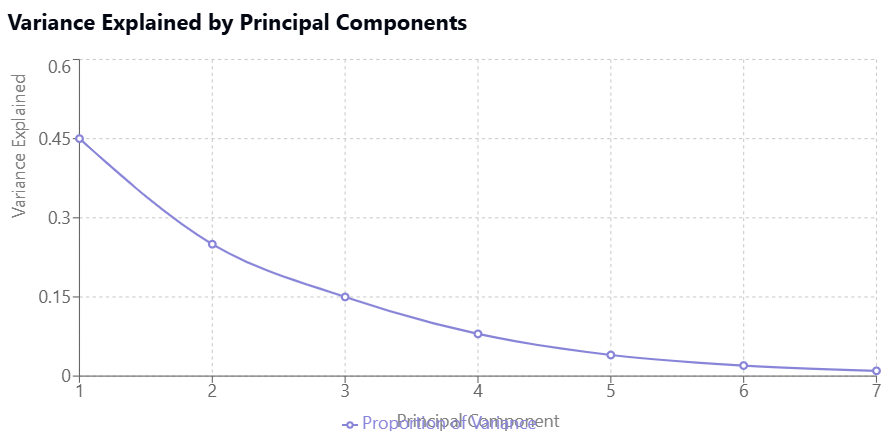

3. Portfolio Optimization:
The code then uses the principal components to create optimized portfolios based on the Sharpe ratio:

$$Sharpe = \frac{R_p - R_f}{\sigma_p}$$

where:
- Rp is the portfolio return
- Rf is the risk-free rate (assumed 0 in this implementation)
- σp is the portfolio standard deviation

4. Hierarchical Clustering:
The second major component implements hierarchical clustering using:
- Correlation matrix as the distance metric
- Average linkage method for cluster formation

The correlation between two stocks i and j is calculated as:

$$\rho_{ij} = \frac{Cov(R_i, R_j)}{\sigma_i \sigma_j}$$

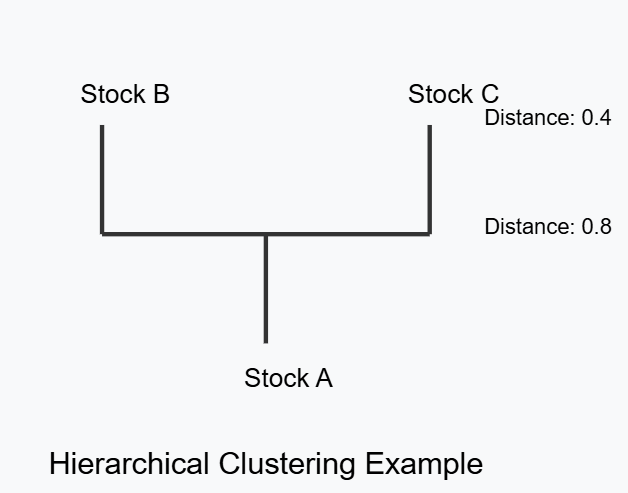

Key Technical Features of the Code:

1. Risk Analysis:
- Calculates annualized returns and volatility
- Implements the Cophenetic correlation coefficient to validate clustering quality
- Uses dendrogram visualization for cluster analysis

2. Performance Optimization:
- Splits data into training (80%) and test (20%) sets
- Implements vectorized operations using NumPy for efficiency
- Uses pandas DataFrame operations for data manipulation

3. Visualization:
- Creates correlation heatmaps
- Plots eigenportfolio weights
- Generates comparative performance charts
- Produces hierarchical clustering dendrograms

The code follows best practices for financial analysis by:
- Properly handling missing data
- Implementing proper train-test splits
- Using standardized financial metrics (Sharpe ratio)
- Providing comprehensive visualizations
- Including error checking and validation metrics

The combination of PCA and hierarchical clustering provides a robust framework for:
- Dimensionality reduction in portfolio optimization
- Understanding market structure through correlation analysis
- Creating diversified portfolios based on statistical measures
- Identifying groups of similarly behaving stocks



In [0]:
from matplotlib import style
import seaborn as sns
from scipy.stats import randint as sp_randint
from sklearn.decomposition import PCA
from pathlib import Path
import pandas as pd
style.use("ggplot")

my_file = Path("data/Dow_adjcloses.csv") # Defines path
if my_file.is_file():              # See if file exists
    print("Local file found")      
    df = pd.read_csv('data/Dow_adjcloses.csv', parse_dates=True, index_col=0)
else:
    print("Be patient: loading from github (2 minutes)")
    df = pd.read_csv(github_p+'data/Dow_adjcloses.csv', parse_dates=True, index_col=0)
    print("Done")
df.head()

Local file found


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.522220,NaN,...,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,NaN,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.899860,NaN,...,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,NaN,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.781550,NaN,...,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,NaN,44.503437,21.097421
2000-01-06,31.877325,33.959430,2.996290,28.553331,15.459153,22.903343,39.781569,17.210031,24.899860,NaN,...,4.677733,16.972739,32.438168,20.122232,20.998392,5.964159,22.449405,NaN,45.126952,20.527220
2000-01-07,32.509812,34.433913,3.138219,29.382213,15.962182,23.305926,42.128682,18.342270,24.506249,NaN,...,4.677733,18.123166,35.023602,20.922479,21.830687,6.662948,22.282692,NaN,48.535033,21.051805


In [0]:
# Dropping 'Not a Number' columns for Dow Chemicals (DWDP) and Visa (V)
df.drop(['DWDP', 'V'], axis=1, inplace=True)
# Copying the dataframe to add features
data = pd.DataFrame(df.copy())
# Daily Returns
# Daily Log Returns (%)
# datareturns = np.log(data / data.shift(1)) 

# Daily Linear Returns (%)
datareturns = data.pct_change(1)

# Dow Jones Equal Weighted rETURN
datareturns["DJIA"] = datareturns.mean(axis=1)

# Data Raw
data_raw = datareturns
data_raw.dropna(how='all', inplace=True)

# Normalizing the returns
data = (data_raw - data_raw.mean()) / data_raw.std()

# Getting rid of the NaN values.
data.dropna(how='any', inplace=True)
data_raw.dropna(how='any', inplace=True)


In [0]:
data.head()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA,DJIA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-2.783305,-1.714531,-3.315064,-0.118649,-0.672149,-0.030177,-2.304726,0.236964,3.089027,-1.283097,...,-2.927985,-2.410473,-1.504783,-0.763609,-2.479568,-0.698935,-2.097284,-2.506437,-2.167895,-2.739489
2000-01-05,3.491453,-0.250475,0.522450,3.667073,1.828679,1.321853,0.305449,0.823741,1.857074,3.247575,...,3.023666,1.148279,-0.671468,0.510782,-0.588825,-0.164440,2.128033,-1.568817,0.502376,1.631646
2000-01-06,3.995818,-0.021248,-3.400666,0.108313,1.770951,2.389941,-1.119210,-0.104682,-1.845881,3.696220,...,-0.316511,2.151911,2.659281,0.070428,2.165327,1.801922,-0.346058,0.914757,-1.584911,0.181378
2000-01-07,1.337698,0.604016,1.791770,1.497066,1.573522,1.067883,2.382987,5.050971,-0.867545,-0.216324,...,-0.041103,4.320217,5.999317,2.158221,2.340150,5.871398,-0.496143,5.006585,1.453883,3.054606
2000-01-10,-0.371257,0.624764,-0.727008,-0.780316,-1.653060,-1.711071,1.482524,-2.486755,8.090552,-0.944732,...,0.855881,-0.131547,-0.413525,-1.026003,0.558540,-0.923939,-0.357794,-1.231132,1.667529,0.250687


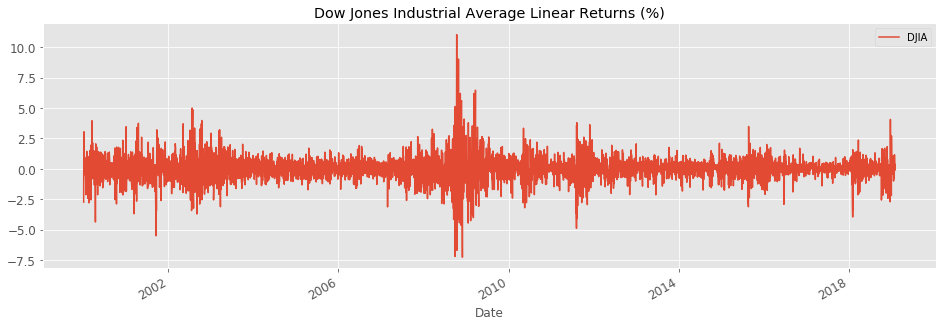

In [0]:
# Visualizing Log Returns for the DJIA a

plt.figure(figsize=(16, 5))
plt.title("Dow Jones Industrial Average Linear Returns (%)")
data.DJIA.plot()
plt.grid(True);
plt.legend()
plt.show()

In [0]:
# Taking away the market benchmark DJIA
stock_tickers = data.columns.values[:-1]
n_tickers = len(stock_tickers)

# Dividing the dataset into training and testing sets
percentage = int(len(data) * 0.8)
X_train = data[:percentage]
X_test = data[percentage:]

X_train_raw = data_raw[:percentage]
X_test_raw = data_raw[percentage:]

# Applying Principle Component Analysis
# Creating covariance matrix and training data on PCA.
cov_matrix = X_train.loc[:,X_train.columns != 'DJIA'].cov()
pca = PCA()
pca.fit(cov_matrix)



PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

21 principal components explain 95.00% of variance


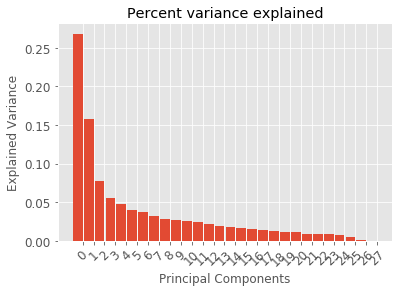

In [0]:
def plotPCA(plot=False):

    # Visualizing Variance against number of principal components.
    cov_matrix_raw = X_train_raw.loc[:,X_train_raw.columns != 'DJIA'].cov()

    var_threshold = 0.95
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  

    if plot:
        print('%d principal components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

        # PCA percent variance explained.
        bar_width = 0.9
        n_asset = stock_tickers.shape[0]
        x_indx = np.arange(n_asset)
        fig, ax = plt.subplots()

        # Eigenvalues measured as percentage of explained variance.
        rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width)
        ax.set_xticks(x_indx + bar_width / 2)
        ax.set_xticklabels(list(range(n_asset)), rotation=45)
        ax.set_title('Percent variance explained')
        ax.set_ylabel('Explained Variance')
        ax.set_xlabel('Principal Components')
        plt.show()

plotPCA(plot=True)

In [0]:
projected = pca.fit_transform(cov_matrix)
pcs = pca.components_

In [0]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in power


Eigen portfolio #24 with the highest Sharpe. Return nan%, vol = 349.81%, Sharpe = nan
      Return       Vol    Sharpe
18  0.653514  0.520659  1.255167
22  0.520714  0.598663  0.869794
4   0.523931  0.634943  0.825162
9   0.434588  0.571939  0.759850
15  0.557383  0.806050  0.691499
0   0.472930  0.687234  0.688165
7   0.552926  1.220988  0.452852
26  0.190378  0.565123  0.336878
13  0.201774  0.750856  0.268725
5   0.033209  0.951549  0.034900


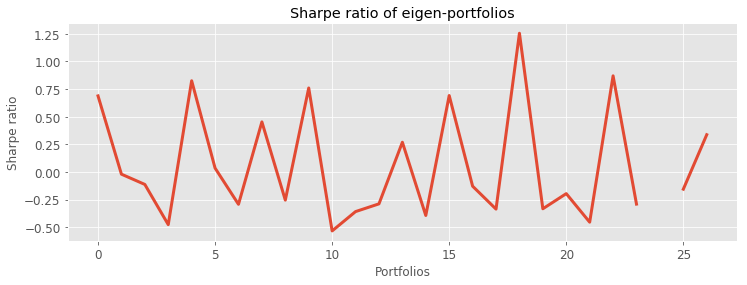

In [0]:
def optimizedPortfolio():
    n_portfolios = len(pcs)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 

    for i in range(n_portfolios):
        
        pc_w = pcs[:, i] / sum(pcs[:, i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        
        eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen_prtfi / n_portfolios)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe

    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(10))

    plt.show()

optimizedPortfolio()

Sum of weights of current eigen-portfolio: 100.00


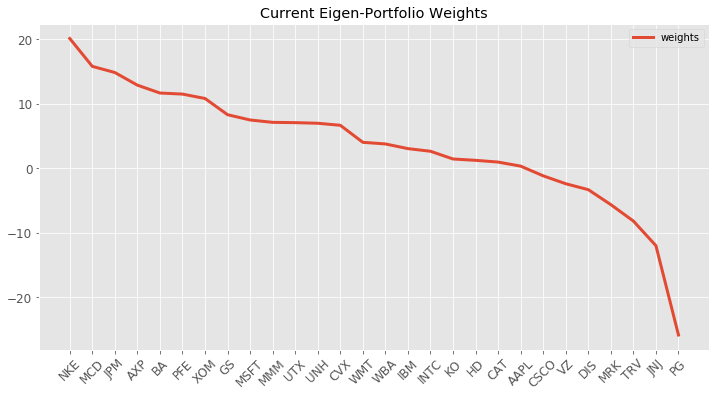

,weights
NKE,20.117567
MCD,15.796158
JPM,14.842129
AXP,12.882346
BA,11.663451
PFE,11.497129
XOM,10.814829
GS,8.299560
MSFT,7.481802
MMM,7.115468


In [0]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pcs)):
        weights["weights_{}".format(i)] = pcs[:, i] / sum(pcs[:, i])

    weights = weights.values.T
    return weights

weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()

    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[4], plot=True)

Current Eigen-Portfolio:
Return = 52.39%
Volatility = 63.49%
Sharpe = 0.83


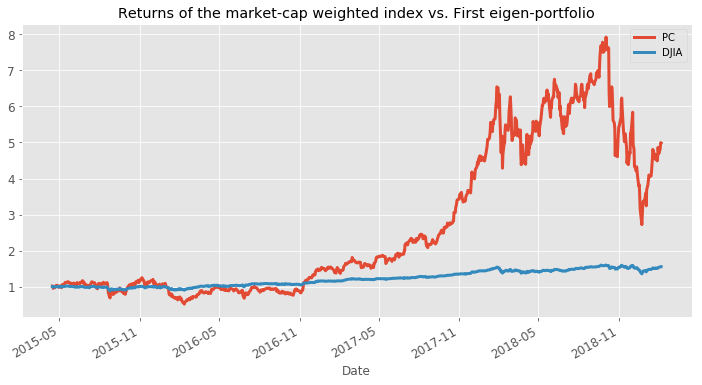

In [0]:
def plotSharpe(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''

    eigen_portfolio_returns = np.dot(X_test_raw.loc[:, eigen.index], eigen / len(pcs))
    eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=X_test.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    year_frac = (eigen_portfolio_returns.index[-1] - eigen_portfolio_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC': eigen_portfolio_returns, 'DJIA': X_test_raw.loc[:, 'DJIA']}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)
    plt.show()

plotSharpe(eigen=plotEigen(weights=weights[4]))

## Investigating Hierarchical Clustering

In [0]:
data.head()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,XOM,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,WMT,WBA,DJIA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-2.783305,-1.714531,-3.315064,-0.118649,-0.672149,-0.030177,-2.304726,0.236964,3.089027,-1.283097,...,-2.927985,-2.410473,-1.504783,-0.763609,-2.479568,-0.698935,-2.097284,-2.506437,-2.167895,-2.739489
2000-01-05,3.491453,-0.250475,0.522450,3.667073,1.828679,1.321853,0.305449,0.823741,1.857074,3.247575,...,3.023666,1.148279,-0.671468,0.510782,-0.588825,-0.164440,2.128033,-1.568817,0.502376,1.631646
2000-01-06,3.995818,-0.021248,-3.400666,0.108313,1.770951,2.389941,-1.119210,-0.104682,-1.845881,3.696220,...,-0.316511,2.151911,2.659281,0.070428,2.165327,1.801922,-0.346058,0.914757,-1.584911,0.181378
2000-01-07,1.337698,0.604016,1.791770,1.497066,1.573522,1.067883,2.382987,5.050971,-0.867545,-0.216324,...,-0.041103,4.320217,5.999317,2.158221,2.340150,5.871398,-0.496143,5.006585,1.453883,3.054606
2000-01-10,-0.371257,0.624764,-0.727008,-0.780316,-1.653060,-1.711071,1.482524,-2.486755,8.090552,-0.944732,...,0.855881,-0.131547,-0.413525,-1.026003,0.558540,-0.923939,-0.357794,-1.231132,1.667529,0.250687


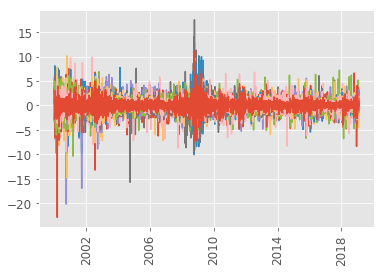

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

#A messy plot of all the processed adjusted closing prices
%matplotlib inline
plt.plot(data);
plt.xticks(rotation='vertical');


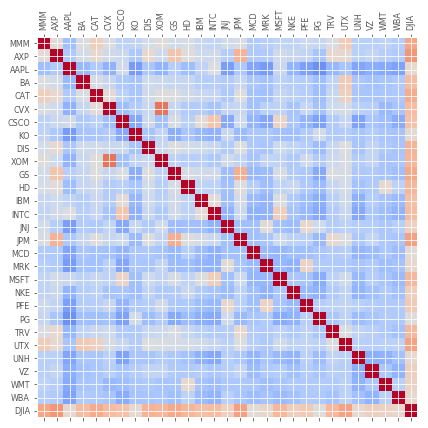

In [0]:
#find correlation matrix, i.e. the "distances" between each stock
corr = data.corr()
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(corr,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=8);



### Clusters of Correlation - Agglomerate



The next step is to look for clusters of correlations using the agglomerate hierarchical clustering technique. Its primary advantage over other clustering methods is that you don't need to guess in advance how many clusters there might be. Agglomerate Clustering first assigns each data point into its own cluster, and gradually merges clusters until only one remains. It's then up to the user to choose a cutoff threshold and decide how many clusters are present.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

There are also different options for the measurement of the distance. The option we will choose is the average distance measurement, but others are possible (ward, single, centroid, etc.).


In [0]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(corr, 'average')
Z[0]

array([5.        , 9.        , 0.27207065, 2.        ])

### Cophenetic Correlation coefficient

It's important to get a sense of how well the clustering performs. One measure is the Cophenetic Correlation Coefficient, c. This compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer c is to 1, the better the clustering preserves the original distances. Generally c > 0.7 is consistered a good cluster fit. Of course, other accuracy checks are possible.

In [0]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import pylab
c, coph_dists = cophenet(Z, pdist(corr))
c

0.7996812457331602

### Dendogram

The best way to visualize an agglomerate clustering algorithm is through a dendogram, which displays a cluster tree, the leaves being the individual stocks and the root being the final single cluster. The "distance" between each cluster is shown on the y-axis, and thus the longer the branches are, the less correlated two clusters are.

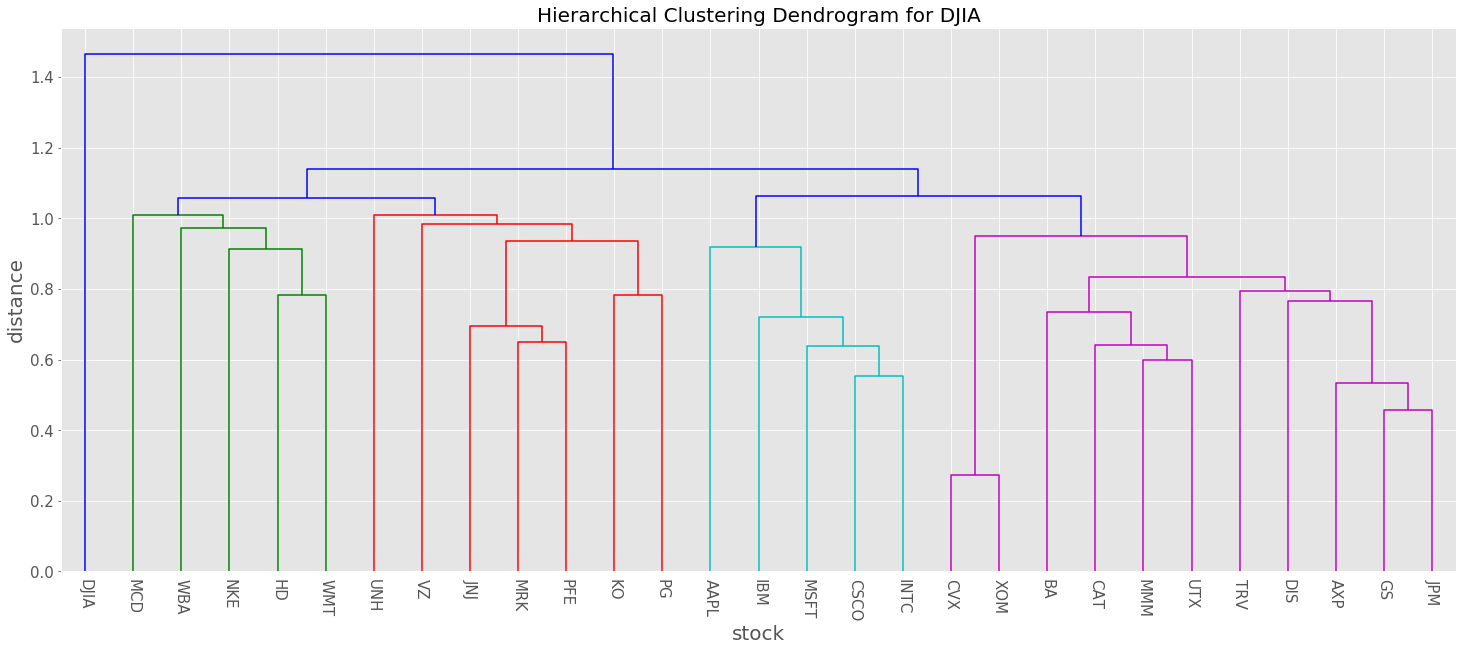

In [0]:
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Hierarchical Clustering Dendrogram for '+"DJIA", fontsize=labelsize)
plt.xlabel('stock', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = corr.columns
)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)
plt.savefig('dendogram_'+'DJIA'+'.png')
plt.show()

According to the dendogram above, the two most correlated stocks are CVX and XOM. That is Chevron Corporation and ExxonMobil. Both businesses are oil corporations, so it makes sense that they would be strongly correlated. Let's plot them below to visually see how well they correlate. In addition, let's pick two stocks that are not well correlated at all to compare to, say, MCD and JPM.

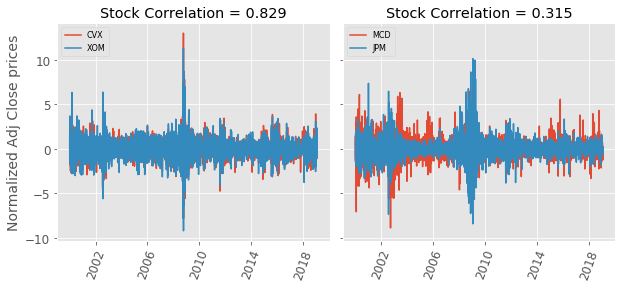

In [0]:
#plot sample correlations
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharey=True)
plt.subplots_adjust(wspace=0.05)

#high correlation
sA = "CVX"
sB = "XOM"
ax1.plot(data[sA],label=sA)
ax1.plot(data[sB],label=sB)
ax1.set_title('Stock Correlation = %.3f'%corr[sA][sB])
ax1.set_ylabel('Normalized Adj Close prices')
ax1.legend(loc='upper left',prop={'size':8})
plt.setp(ax1.get_xticklabels(), rotation=70);

#low correlation
sA = "MCD"
sB = "JPM"
ax2.plot(data[sA],label=sA)
ax2.plot(data[sB],label=sB)
ax2.set_title('Stock Correlation = %.3f'%corr[sA][sB])
ax2.legend(loc='upper left',prop={'size':8})
plt.setp(ax2.get_xticklabels(), rotation=70);